<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.0
IPython 5.1.0

numpy 1.11.3
scipy 0.18.1
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.3.2


##  1.1. Линейная регрессия и SGD

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [3]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=0.001, n_iter=10):
        self.mse_=[]
        self.weights_=[]
        self.eta=eta
        self.n_iter=n_iter
        
    def fit(self, X, y):
        X_m=np.append(np.full((X.shape[0],1),1,dtype=int), X, axis=1)
        self.w=np.zeros(X_m.shape[1])
        self.weights_=[self.w]
        self.mse_=np.append(self.mse_, self.MSE(X_m, y))
        for i in range(self.n_iter):
            for j in range(X_m.shape[0]):
                self.GD(X_m[j], y[j])
            self.mse_=np.append(self.mse_, self.MSE(X_m, y))
            self.weights_=np.append(self.weights_, [self.w], axis=0)
        self.w_=self.weights_[np.argmin(self.mse_)]
        return self
    
    def predict(self, X):
        X_m=np.append(np.full((X.shape[0],1),1,dtype=int), X, axis=1)
        return self.w_@np.transpose(X_m)
        
    def MSE(self, X, y):
        return mean_squared_error(y, self.w@np.transpose(X))
    
    def GD(self, X, y):
        X=np.array([X])
        self.w=self.w+self.eta*((y-self.w@np.transpose(X))@X)/X.shape[0]
        return self

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [4]:
data_demo = pd.read_csv('../data/weights_heights.csv')

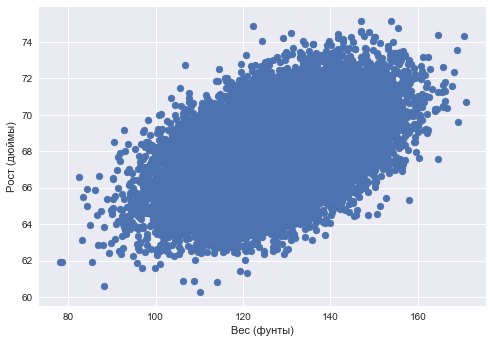

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [6]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [9]:
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)

SGDRegressor(eta=0.001, n_iter=10)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

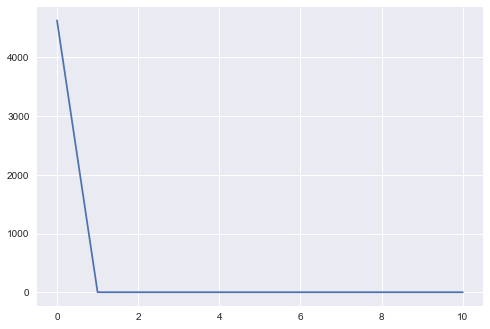

In [10]:
plt.plot(sgd.mse_)

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [11]:
np.min(sgd.mse_), sgd.w_

(2.7186529249117402, array([ 68.0379205 ,   0.91137808]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

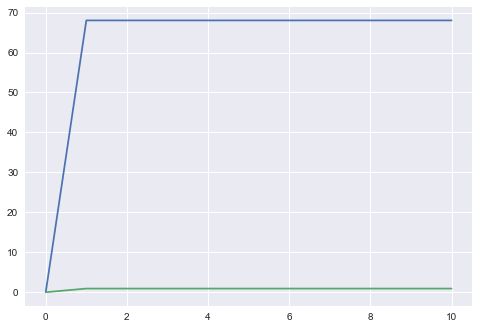

In [12]:
plt.plot(sgd.weights_)

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [13]:
mean_squared_error(y_valid, sgd.predict(X_valid_scaled))

2.6758567247697678

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
mean_squared_error(y_valid, lr.predict(X_valid_scaled))

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - <b>3</b>
 - 4
 - 5

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - <b>$w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$</b>
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [15]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [16]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C, eta=0.001, n_iter=10):
        self.loss_=[]
        self.weights_=[]
        self.C=C
        self.eta=eta
        self.n_iter=n_iter
        
    def fit(self, X, y):
        X_m=np.append(np.full((X.shape[0],1),1,dtype=int), X, axis=1)
        self.kronecker=np.full(X_m.shape[1],1,dtype=int)
        self.kronecker[0]=0
        self.w=np.zeros(X_m.shape[1])
        self.weights_=[self.w]
        self.loss_=np.append(self.loss_, self.loss(X_m, y))
        for i in range(self.n_iter):
            for j in range(X_m.shape[0]):
                self.GD(X_m[j], y[j])
            self.loss_=np.append(self.loss_, self.loss(X_m, y))
            self.weights_=np.append(self.weights_, [self.w], axis=0)
        self.w_=self.weights_[np.argmin(self.loss_)]
        return self
    
    def predict_proba(self, X):
        X_m=np.append(np.full((X.shape[0],1),1,dtype=int), X, axis=1)
        return self.w_@np.transpose(X_m)
    
    def predict(self, X):
        return [-1 if p<0.5 else 1 for p in self.predict_proba(X)]
        
    def loss(self, X, y):
        return log_loss(y, self.w@np.transpose(X))
    
    def GD(self, X, y):
        self.w=self.w+self.eta*(self.C*y*X*sigma(-y*self.w@X)-self.kronecker*self.w)
        return self      

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [17]:
from sklearn.datasets import load_breast_cancer

In [18]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [21]:
sgd_clf=SGDClassifier(C=1,eta=0.001,n_iter=3)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

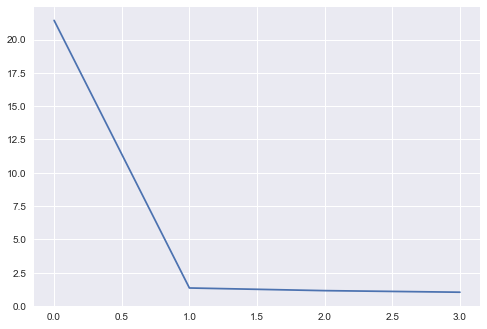

In [22]:
plt.plot(sgd_clf.loss_)

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [23]:
sgd_clf_strong=SGDClassifier(C=1000,eta=0.001,n_iter=10)
sgd_clf_strong.fit(X_train_scaled, y_train)
sgd_clf_strong.w_

array([ 2.96821874, -1.17107667, -1.43296306, -1.03307127, -1.27569056,
       -0.59385402,  1.23444412, -3.52795876, -3.52388465,  0.53551646,
        0.81432566, -3.88170108,  2.14088645, -2.21446383, -2.67433289,
       -0.32569304,  4.83647811,  0.55223557, -0.42466808, -0.22614934,
        4.37369555, -2.18579849, -3.35134967, -1.22979514, -1.96244397,
       -2.24465133, -0.19462159, -4.65935884, -1.69908445, -1.09279954,
       -1.64113182])

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - <b>compactness error</b>
 - worst fractal dimension

In [24]:
sgd_clf_strong.w_.shape[0], X_train_scaled.shape[1]

(31, 30)

In [25]:
cancer.feature_names[np.argmax(sgd_clf_strong.w_)-1]

'compactness error'

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [26]:
log_loss(y_valid, sgd_clf_strong.predict(X_valid_scaled)), roc_auc_score(y_valid, sgd_clf_strong.predict(X_valid_scaled))

(1.2119149470996808, 0.95081967213114749)

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=17)
lr.fit(X_train_scaled, y_train)
log_loss(y_valid, lr.predict(X_valid_scaled)), roc_auc_score(y_valid, lr.predict(X_valid_scaled))

(0.80794329806645415, 0.96721311475409844)

## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [28]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [29]:
imdb_folder = '/Users/uladzimir_artsemenka/Downloads/aclImdb'

reviews_train = load_files(imdb_folder+'/train')
text_train, y_train = reviews_train.data, reviews_train.target

In [35]:
reviews_test = load_files(imdb_folder+'/test')
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [36]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 36.3 s, sys: 837 ms, total: 37.2 s
Wall time: 37.5 s


In [37]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [60]:
%%time
from sklearn.linear_model import LogisticRegression
imdb_clf = LogisticRegression(random_state=17)
imdb_clf.fit(X_train, y_train)
roc_auc_score(y_test, imdb_clf.predict_proba(X_test)[:,1])

CPU times: user 1min 9s, sys: 400 ms, total: 1min 9s
Wall time: 1min


In [61]:
roc_auc_score(y_test, imdb_clf.predict_proba(X_test)[:,1])

0.95824837120000006

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - <b>Изменяемый шаг градиентного спуска</b>
 - <b>Реализован линейный SVM</b>
 - Реализована ранняя остановка во избежание переобучения
 - <b>Есть распараллеливание по процессорам</b>
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - <b>Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)</b>


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [57]:
%%time

imdb_clf = SGDClassifier(random_state=17, n_iter=100, loss='log')
imdb_clf.fit(X_train, y_train)
roc_auc_score(y_test, imdb_clf.predict_proba(X_test)[:,1])

CPU times: user 9.57 s, sys: 67.8 ms, total: 9.63 s
Wall time: 9.62 s


In [59]:
roc_auc_score(y_test, imdb_clf.predict_proba(X_test)[:,1])

0.95734586880000005

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - <b>3</b>
 - 4
 - 5